In [1]:
from IPython.display import display, Markdown
with open('readme.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

# Code instructions
In this Jupyter Notebook you can find my solution to the second project for the course *Introduction to Data Mining*.
This Notebook contains both the code and the report.

## Loading the Data
In order to load the required data into this Notebook, the Notebook needs to be placed in the same directory
as two folders with the name **train** and **test**. Inside the **train** folder there should be three subfolders:
**course**, **faculty** and **student**. These three subfolders should contain the HTML-files for respectively
the course webpages, the faculty webpages and the student webpages.

The **test** folder is where all the test data needs to be stored.

## Installing the libraries
This Notebook is written in Python 2.7 and requires some non-standard libraries. If these libraries are not
installed on your machine, some cells of code will give errors. Below is a list of required libraries.

- NLTK
- Matplotlib
- Scipy
- Numpy
- Sklearn
- Pandas
- Time
- Bs4

In feature engineering section, the stopword list from Python's NLTK will need to be downloaded. The command for downloading this list is already included in the code. This command will however need to be uncommented first.


# Introduction to Data Mining: Project 2

In this project, the goal is to define a model that can predict whether an html-page from an academic institution belongs to a student, a course or a member of the academic staff. In order to do this, the data will have to be loaded and pre-processed. Features have to be defined and different classifiers with varying parameters will be tested on the test-data to find the most adequate one. The accuracy results for the different classifiers will be evaluated. After finding the optimal model, both in terms of predicting performance and speed, this model will be applied to the full test data.

First, the full train data will be loaded into a Pandas DataFrame. This DataFrame will contain two columns: one for the actual html-file that is loaded and one for its corresponding category. The first cell will also load some modules that might come in handy afterwards such as BeautifulSoup to parse html-files and Python's Natural Language ToolKit for performing text analysis.

In [2]:
import pandas as pd
import os
import nltk
from bs4 import BeautifulSoup
from nltk.stem.porter import *     # after getting errors with importing nltk, changed ../tests/compat_fixt.py to ../tests/compat.py
def readData(path):
    data = pd.DataFrame(index=[], columns=['text','category'])
    ind = 0
    for cat in os.listdir(path):
        for f in os.listdir(path+'\\'+cat):    
                content = open(path+'\\'+cat+'\\'+f).read()                   
                data.loc[ind] = [content,cat]
                ind = ind + 1
    return data

In [3]:
full_train_data = readData('C:\Users\Tim\Documents\KU Leuven\Master digital humanities\Introduction to data mining\Project\dm-project\\train')
print full_train_data.shape
full_train_data.head()

(2464, 2)


,text,category
0,<HEAD>\n<TITLE>CSE 121/131 Home Page</TITLE>\n...,course
1,"Date: Tue, 26 Nov 1996 19:10:40 GMT\nServer: N...",course
2,"Date: Tue, 26 Nov 1996 19:12:30 GMT\nServer: N...",course
3,"Date: Tuesday, 26-Nov-96 19:09:20 GMT\nServer:...",course
4,"Date: Tuesday, 26-Nov-96 19:07:04 GMT\nServer:...",course


## 1. Feature Engineering


Now that the train data is loaded into the DataFrame a next step is to define meaningful features and convert these to a feature-vector format so they can eventually be applied to the classifiers. In order to do this, a new DataFrame will contain the features that are defined.

### First feature set

A first set of features looks at the actual structure of the pages. It is for example likely that a webpage for a student or a faculty member will contain an image while a course webpage does not. Similarly, students and perhaps even faculty members will have more than one email-address included on their webpage - professional and personal - while courses are likely to contain only one email-address. Maybe even more interesting is the old address tag which is an indication of the inclusion of contact information on the author. Finally, it seems that some students tend to style their homepages while the pages for faculty and courses are far more sober. For this reason there will also be a feature included that keeps track of a styling element. More concrete, this first feature set will use the BeautifulSoup library to parse the html-pages and look for specific elements in these pages, their presence or absence will serve as features. The features are: the absence or presence of an image, the amount of links, the amount of addresses and the presence or absence of a colour attribute in one of the elements of the webpage.

In [4]:
features1 = pd.DataFrame()

In [5]:
images = []
for im in full_train_data['text']:
    im_check = 0
    if BeautifulSoup(im).find_all("img"):
        im_check = 1
    images.append(im_check)
features1['images'] = images

C:\Users\Tim\Anaconda2\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Users\Tim\Anaconda2\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Image seems to do be a decent start. About 50 % for every classifier, maybe even better when counting!!. Afterwards: describe all these features separate like you did it --> first images than the keywords etc... + also: first True and False, than counting etc...

In [6]:
link = []
for ad in full_train_data['text']:
    ad_check = 0
    ad_check = len(BeautifulSoup(ad).find_all("a"))
    link.append(ad_check)
features1['link'] = link

In [7]:
address = []
for ad in full_train_data['text']:
    ad_check = 0
    ad_check = len(BeautifulSoup(ad).find_all("address"))
    address.append(ad_check)
features1['address'] = address

In [8]:
background = []
for ad in full_train_data['text']:
    ad_check = 0
    if BeautifulSoup(ad).find_all(attrs={"color":True}):
        ad_check = 1
    background.append(ad_check)
features1['background'] = background

In [9]:
features1.head()

,images,link,address,background
0,1,18,0,0
1,0,28,0,0
2,0,25,0,0
3,1,16,0,0
4,0,5,0,0


### Second feature set

A second feature selection consists of the Bag Of Words approach. More specifically, I will use Scikit's Countvectorizer module to implement the tfidf-method on the different pages in order to calculate the importance of the words for each page. To get the tfidf-scores, the pages will first need to be fully parsed to retrieve their plain text only without the HTML-tags. The BeautifulSoup library will once again serve beautifully to do this. For the sake of consistency I will also put the tfidf-results for each page into a DataFrame which requires some data transformation steps.

In [10]:
features2 = pd.DataFrame()

In [11]:
full = []
for item in full_train_data['text']:   
    plain_text = BeautifulSoup(item).get_text()
    full.append(plain_text)
full_train_data['plainText'] = full

In an attempt to improve the efficiency of this feature set, I will manually remove some stopwords using the NLTK stopword list. Although the tfidf-method already decreases the weight of stopwords, completely deleting the stopwords manually might improve the performance of the tfidf-feature.

In [12]:
# nltk.download('stopwords')  --> downloads the stopwords list from NLTK!!!!
stop = nltk.corpus.stopwords.words('english')
for i in range(len(full_train_data['plainText'])):
    fil = []
    for word in full_train_data['plainText'][i].split():
        if word.lower() not in stop:
            fil.append(word)
    full_train_data['plainText'][i] = " ".join(fil)

In [13]:
full_train_data.head()

,text,category,plainText
0,<HEAD>\n<TITLE>CSE 121/131 Home Page</TITLE>\n...,course,CSE 121/131 Home Page CSE 121/131 Home Page Pr...
1,"Date: Tue, 26 Nov 1996 19:10:40 GMT\nServer: N...",course,"Date: Tue, 26 Nov 1996 19:10:40 GMT Server: NC..."
2,"Date: Tue, 26 Nov 1996 19:12:30 GMT\nServer: N...",course,"Date: Tue, 26 Nov 1996 19:12:30 GMT Server: NC..."
3,"Date: Tuesday, 26-Nov-96 19:09:20 GMT\nServer:...",course,"Date: Tuesday, 26-Nov-96 19:09:20 GMT Server: ..."
4,"Date: Tuesday, 26-Nov-96 19:07:04 GMT\nServer:...",course,"Date: Tuesday, 26-Nov-96 19:07:04 GMT Server: ..."


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(full_train_data['plainText'])
X_train_counts.shape

(2464, 37346)

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=False).fit(X_train_counts)
X_train_tfidf = transformer.transform(X_train_counts)
features2['tfidf'] = list(X_train_tfidf.toarray())
features2.head()

,tfidf
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054684841401,..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Third feature set

A third set of features is somewhat similar to the tfidf-calculations. Instead of taking the relevance of all the words into account, this feature set will be looking at the frequency of specific keywords and try to predict the category of a webpage based on these frequencies. A loop will iterate over all the actual words in a file and stem this word using the Porter Stemmer from the NLTK library. Then, this stemmed word will be checked for its appearance in a list of meaningful words that are stemmed as well. If there is a match, the frequency of the feature for that specific file will go up. This process will be repeated for three keyword lists, one containing words associated with faculty members, another with words related to courses and a last one with keywords on students. The frequency of these features will again be stored into a DataFrame.

In [16]:
features3 = pd.DataFrame()

In [17]:
ps = nltk.stem.PorterStemmer()

In [18]:
faculty_terms = ["director", "board", "member", "contact", "research", "faculty", "teaching", "professor", "member", "professor", "i", "dr.", "phd"]
faculty_stem = []
faculties = []
for term in faculty_terms:
    new = ps.stem(term)
    faculty_stem.append(new)
for i in range(len(full_train_data['plainText'])):
    fac_check = 0
    for word in full_train_data['plainText'][i].split():
        if ps.stem(word.lower()) in faculty_stem:
            fac_check += 1
    faculties.append(fac_check)
features3['faculty'] = faculties
features3['faculty'] = features3['faculty'].values.reshape(-1, 1)

In [19]:
course_terms = ["course", "exam", "materials", "homework", "exams", "textbook", "syllabus", "handouts", "notes", "eecs"]
course_stem = []
courses = []
for term in course_terms:
    new = ps.stem(term)
    course_stem.append(new)
for i in range(len(full_train_data['plainText'])):
    course_check = 0
    for word in full_train_data['plainText'][i].split():
        if ps.stem(word.lower()) in course_stem:
            course_check += 1
    courses.append(course_check)
features3['course'] = courses
features3['course'] = features3['course'].values.reshape(-1, 1)

In [20]:
student_terms = ["am", "progress", "student", "homepage", "address", "my", "phd"]
student_stem = []
students = []
for term in student_terms:
    new = ps.stem(term)
    student_stem.append(new)
for i in range(len(full_train_data['plainText'])):
    stud_check = 0
    for word in full_train_data['plainText'][i].split():
        if ps.stem(word.lower()) in student_stem:
            stud_check += 1
    students.append(stud_check)
features3['student'] = students
features3['student'] = features3['student'].values.reshape(-1, 1)

In [21]:
features3.head()

,faculty,course,student
0,1,3,0
1,1,12,3
2,3,16,2
3,0,4,3
4,0,4,0


The next line will merge the three sets together into one data matrix and written into the file 'featurematrix.csv'.

In [22]:
feature_matrix = pd.concat([features1, features2, features3], axis=1)
feature_matrix.to_csv('featurematrix.csv', sep='|', encoding='utf-8', index=False)

## 2. Models

Next, the three different featuresets will be used to train models and to make predictions for the web pages. In order to do this, a dummy baseline model will first be created to predict the majority class. Next, a total of four different classifiers will be used. The selected classifiers all belong to different so-called 'tribes'. From the field of linear classifiers, I chose logistic regression for its simplicity and speed. Secondly, the K-Nearest Neighbour classifier will make predictions based on association. From the symbolic classifiers, the decision tree classifier was selected. As an extension to this, random forest was chosen to try and obtain higher results with this ensemble learning method. Finally, a linear support vector machine will be implemented, namely stochastic gradient descent, for its proven effectiveness on textual data.

Each model will also immediately get evaluated on its performance. In order to evaluate the performance of the classifier, two metrics will be used. First, the actual predicting accuracy of the classifier will be tested on ten different subsamples of an equal size. The full training set will be split into these ten subsets using k-fold cross-validation where k=10. This will result in ten accuracy values for the model of which the mean will be calculated. Secondly, to get an idea on how meaningful this accuracy measure is, a confusion matrix will be constructed. This will be done by splitting the train data into a new train set and a tune test set where the last one in one third of the size of the first one. After that, a confusion matrix will show how many of the examples were correctly predicted. Please note that although I mostly make use of the sklearn modules, I used pandas for the splitting and the construction of the confusion matrices for its insightful overview. For every classifier there is also some information on the training and predicting time since the can also be an important variable when choosing a model.

In [23]:
from sklearn.cross_validation import cross_val_score
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from time import time
from sklearn.grid_search import GridSearchCV
from operator import itemgetter
import scipy as sp
from scipy.stats import t
from scipy import stats

The next function is meant for calculating the 95% confidence interval for every model.

In [24]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return "95% confidence interval: "  + str((m-h, m+h))

### Dummy classifier

Feature set 1: 

training time:  0.002 s

predicting time:  0.195 s

0.372469635628
0.376518218623
0.364372469636
0.356275303644
0.426829268293
0.325203252033
0.325203252033
0.361788617886
0.390243902439
0.378048780488

0.36769527007

95% confidence interval: (0.34636665722012128, 0.38902388292009793)

Predicted  course  faculty  student  All
True                                    
course         57       59      105  221
faculty        54       71      122  247
student        89      114      143  346
All           200      244      370  814


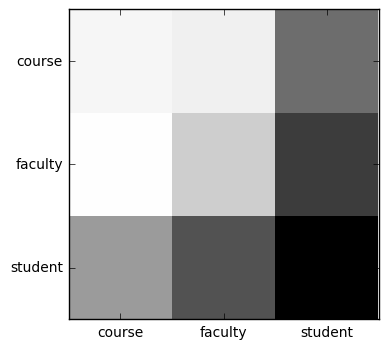


Feature set 2: 

training time:  0.002 s

predicting time:  1.392 s

0.348178137652
0.364372469636
0.315789473684
0.303643724696
0.317073170732
0.345528455285
0.333333333333
0.308943089431
0.341463414634
0.353658536585

0.333198380567

95% confidence interval: (0.31838344067089697, 0.34801332046270628)

Predicted  course  faculty  student  All
True                                    
course         55       69       97  221
faculty        65       66      116  247
student        76      118      152  346
All           196      253      365  814


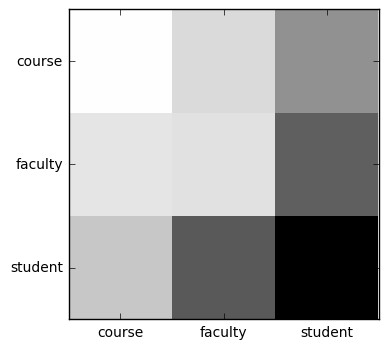


Feature set 3: 

training time:  0.002 s

predicting time:  0.149 s

0.36032388664
0.384615384615
0.323886639676
0.327935222672
0.369918699187
0.317073170732
0.378048780488
0.386178861789
0.325203252033
0.321138211382

0.349432210921

95% confidence interval: (0.3287887932031528, 0.37007562863944621)

Predicted  course  faculty  student  All
True                                    
course         57       67       97  221
faculty        63       75      109  247
student        78      118      150  346
All           198      260      356  814


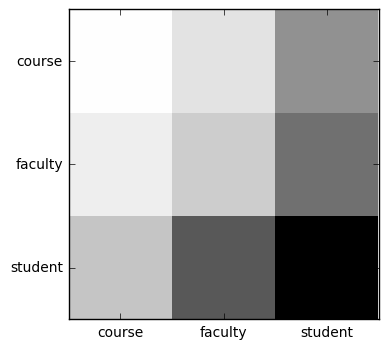

In [43]:
from sklearn.dummy import DummyClassifier
def dumClass(feature_set):
    classifier = DummyClassifier()
    x_train, x_test  = train_test_split(feature_set, test_size = 0.33, random_state=42)
    y_train, y_test = train_test_split(full_train_data['category'], test_size = 0.33, random_state=42)
    t0 = time()
    classifier.fit(x_train, y_train)
    print 'training time: ', round(time()-t0, 3), 's'
    print
    t1 = time()
    accuracies = cross_val_score(classifier, feature_set, full_train_data['category'], cv=10) #volledige data gebruiken want split automatisch!!!!!
    print 'predicting time: ', round(time()-t1, 3), 's'
    print
    for acc in accuracies:
        print acc
    print
    print np.mean(accuracies)
    print
    print mean_confidence_interval(accuracies)
    print
    

    y_pred = classifier.fit(x_train, y_train).predict(x_test)
    
    conf = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    print conf
    im = plt.imshow(conf.iloc[0:3, 0:3], cmap='binary', interpolation='None')
    plt.xticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.yticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.show(im)
    return accuracies, conf, im
print "Feature set 1: "
print
dumClass(features1)
print
print "Feature set 2: "
print
dumClass(features2['tfidf'].tolist())
print
print "Feature set 3: "
print
dumClass(features3)
print

The dummy classifier shows low accuracy rates for all feature sets which is not a surprise. What is interesting for the analysis of the real classifiers are the results from the confusion matrix. The matrix shows a tendency in predicting towards the majority class which is 'students'. 

### Logistic regression classifier

A first prediction model that will be applied to all three sets of features is the Logistic regression classifier. This simple prediction model tends to work well in practice and might give some first insights on the effectivity of the features. The fact that it works relatively fast is also an advantage when using the tfidf-values. I selected the logistic regression classifier over the other statistical classifier naïve bayes because I expect it will have slightly better predicting results. To obtain the best parameters for the best feature set possible, a grid search over a number of parameters will first be conducted.

In [26]:
from sklearn.linear_model import LogisticRegression
def log_gridsearch(feature_set, clf, param_grid, cv=4):

    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    x_train, x_test  = train_test_split(feature_set, test_size = 0.33, random_state=42)
    y_train, y_test = train_test_split(full_train_data['category'], test_size = 0.33, random_state=42)
    start = time()
    grid_search.fit(x_train, y_train)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.grid_scores_)))

    print sorted(grid_search.grid_scores_, key=itemgetter(1), reverse=True)[1]
    return sorted(grid_search.grid_scores_, key=itemgetter(1), reverse=True)[1]

log_gridsearch(features1, LogisticRegression(), {
              "penalty": ["l1", "l2"],
              "fit_intercept": [False, True],
              "class_weight": [None, "balanced"],
              "random_state": [None, 10, 20, 50]})
log_gridsearch(features2['tfidf'].tolist(), LogisticRegression(), {
              "penalty": ["l2", "l1"],
              "fit_intercept": [False, True],
              "class_weight": [None, "balanced"],
              "random_state": [None, 10, 20, 40, 50],
              })
log_gridsearch(features3, LogisticRegression(), {
              "penalty": ["l2", "l1"],
              "fit_intercept": [False, True],
              "class_weight": [None, "balanced"],
              "random_state": [None, 10, 20, 50]})


GridSearchCV took 3.39 seconds for 32 candidate parameter settings.
mean: 0.50121, std: 0.01126, params: {'penalty': 'l1', 'random_state': 20, 'fit_intercept': False, 'class_weight': 'balanced'}

GridSearchCV took 163.99 seconds for 40 candidate parameter settings.
mean: 0.90485, std: 0.02409, params: {'penalty': 'l2', 'random_state': 10, 'fit_intercept': False, 'class_weight': 'balanced'}

GridSearchCV took 3.30 seconds for 32 candidate parameter settings.
mean: 0.77636, std: 0.01592, params: {'penalty': 'l2', 'random_state': 10, 'fit_intercept': True, 'class_weight': None}


mean: 0.77636, std: 0.01592, params: {'penalty': 'l2', 'random_state': 10, 'fit_intercept': True, 'class_weight': None}

Feature set 1: 

training time:  0.016 s

predicting time:  0.379 s

0.473684210526
0.449392712551
0.477732793522
0.46963562753
0.455284552846
0.520325203252
0.569105691057
0.630081300813
0.451219512195
0.475609756098

0.497207136039

95% confidence interval: (0.45476718962763807, 0.53964708245030535)

Predicted  course  faculty  student  All
True                                    
course        123       18       80  221
faculty        43       84      120  247
student        69       64      213  346
All           235      166      413  814


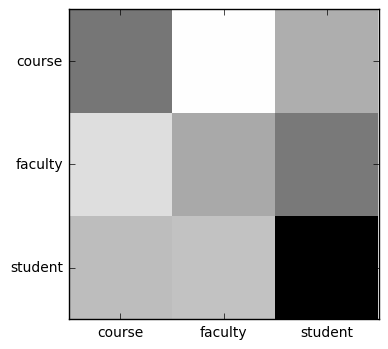


Feature set 2: 

training time:  1.228 s

predicting time:  15.459 s

0.939271255061
0.927125506073
0.886639676113
0.898785425101
0.906504065041
0.943089430894
0.910569105691
0.89837398374
0.910569105691
0.882113821138

0.910304137454

95% confidence interval: (0.89552544406165335, 0.92508283084700671)

Predicted  course  faculty  student  All
True                                    
course        195        5       21  221
faculty         3      226       18  247
student        10       11      325  346
All           208      242      364  814


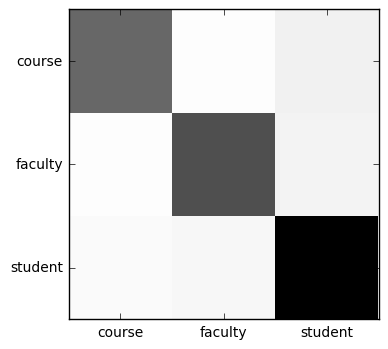


Feature set 3: 

training time:  0.019 s

predicting time:  0.376 s

0.619433198381
0.68016194332
0.708502024291
0.708502024291
0.760162601626
0.731707317073
0.69918699187
0.686991869919
0.626016260163
0.731707317073

0.695237154801

95% confidence interval: (0.66317796096310344, 0.72729634863829218)

Predicted  course  faculty  student  All
True                                    
course        206        8        7  221
faculty        15      211       21  247
student        83       90      173  346
All           304      309      201  814


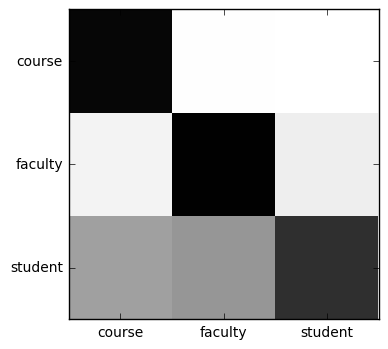

In [44]:
from sklearn.linear_model import LogisticRegression

def logReg(feature_set):
    classifier = LogisticRegression(penalty='l1', random_state=10,dual=False, class_weight="balanced", fit_intercept= False)
    x_train, x_test  = train_test_split(feature_set, test_size = 0.33, random_state=42)
    y_train, y_test = train_test_split(full_train_data['category'], test_size = 0.33, random_state=42)
    t0 = time()
    classifier.fit(x_train, y_train)
    print 'training time: ', round(time()-t0, 3), 's'
    print
    t1 = time()
    accuracies = cross_val_score(classifier, feature_set, full_train_data['category'], cv=10)
    print 'predicting time: ', round(time()-t1, 3), 's'
    print
    for acc in accuracies:
        print acc
    print
    print np.mean(accuracies)
    print
    print mean_confidence_interval(accuracies)
    print

    y_pred = classifier.fit(x_train, y_train).predict(x_test)
    
    conf = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    print conf
    im = plt.imshow(conf.iloc[0:3, 0:3], cmap='binary', interpolation='None')
    plt.xticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.yticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.show(im)
    return accuracies, conf, im
print "Feature set 1: "
print
logReg(features1)
print
print "Feature set 2: "
print
logReg(features2['tfidf'].tolist())
print
print "Feature set 3: "
print
logReg(features3)
print

I did not use the accuracies directly from the grid search since I only used 4-fold cross-validation to limit the time. To get a complete idea on all the metrics of this classifier, I then used the optimal parameters for an evaluation of the logistic regression classifier for the different feature sets with 10-fold cross-validation. After some parameter tuning, the accuracies were higher than those of the grid search so I used these manually adjusted parameters.

Some conclusions can be drawn from the results of this first basic classifier. First of all, the first feature set seems to have only very limited predicting capacities. Although the difference between the results for the first set of features of the dummy baseline and those of the logistic regression model is significant, it is not very large. In contrast to that, there is a very big difference between the accuracy results of the logistic regression model and the dummy classifier for the two other sets of features. Using the tfidf-values, the mean of the ten different accuracies reach up to 85% with l2 regularisation and over 88% when using l1 regularisation, which is also faster. The other metrics for this feature are good as well. The matrix shows only limited confusion towards the student class and the 95% confidence interval is fairly small.

### K-Nearest neighbor classifier

The next classifier that will be tried out for prediction with the three different feature sets is K-Nearest neighbors. I do not have very high expectations for this classifier because of its very low bias. Moreover, because of its slow query-time, I had to use a different n_neighbors parameter for the tfidf-features than for the other feature sets since the processing was taking up too much time.

Feature set 1: 

training time:  0.003 s

predicting time:  0.658 s

0.485829959514
0.493927125506
0.497975708502
0.449392712551
0.471544715447
0.544715447154
0.50406504065
0.49593495935
0.479674796748
0.475609756098

0.489867022152

95% confidence interval: (0.47198101049783081, 0.50775303380617498)

Predicted  course  faculty  student  All
True                                    
course         50       27      144  221
faculty        18       91      138  247
student        33       72      241  346
All           101      190      523  814


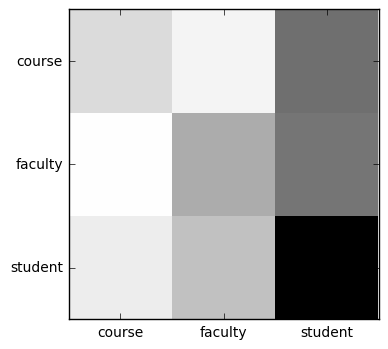


Feature set 2: 

training time:  0.673 s

predicting time:  35.126 s

0.696356275304
0.744939271255
0.708502024291
0.712550607287
0.735772357724
0.707317073171
0.646341463415
0.670731707317
0.784552845528
0.776422764228

0.718348638952

95% confidence interval: (0.68729981727039768, 0.74939746063355539)

Predicted  course  faculty  student  All
True                                    
course        212        5        4  221
faculty        16      184       47  247
student        17       37      292  346
All           245      226      343  814


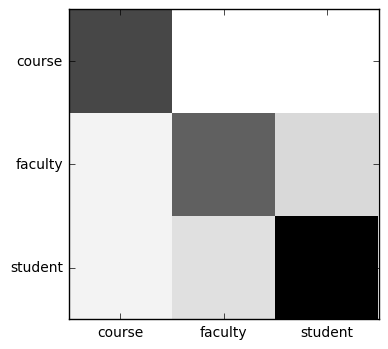


Feature set 3: 

training time:  0.003 s

predicting time:  0.477 s

0.757085020243
0.761133603239
0.846153846154
0.793522267206
0.821138211382
0.772357723577
0.760162601626
0.764227642276
0.772357723577
0.821138211382

0.786927685066

95% confidence interval: (0.76417566725750374, 0.80967970287514501)

Predicted  course  faculty  student  All
True                                    
course        195        2       24  221
faculty        11      177       59  247
student        22       45      279  346
All           228      224      362  814


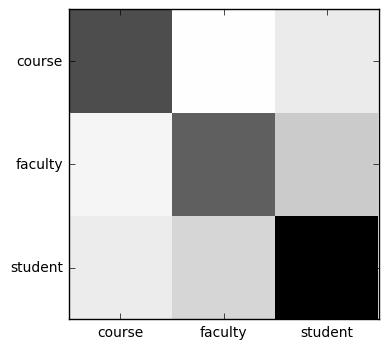

In [45]:
from sklearn.neighbors import KNeighborsClassifier

def knnClass(feature_set, k, l):
    classifier = KNeighborsClassifier(n_neighbors=k, algorithm='brute', leaf_size=l)
    x_train, x_test  = train_test_split(feature_set, test_size = 0.33, random_state=42)
    y_train, y_test = train_test_split(full_train_data['category'], test_size = 0.33, random_state=42)
    t0 = time()
    classifier.fit(x_train, y_train)
    print 'training time: ', round(time()-t0, 3), 's'
    print
    t1 = time()
    accuracies = cross_val_score(classifier, feature_set, full_train_data['category'], cv=10)
    print 'predicting time: ', round(time()-t1, 3), 's'
    print
    for acc in accuracies:
        print acc
    print
    print np.mean(accuracies)
    print
    print mean_confidence_interval(accuracies)
    print

    y_pred = classifier.fit(x_train, y_train).predict(x_test)
    
    conf = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    print conf
    im = plt.imshow(conf.iloc[0:3, 0:3], cmap='binary', interpolation='None')
    plt.xticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.yticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.show(im)
    return accuracies, conf, im
print "Feature set 1: "
print
knnClass(features1, 30, 20)
print
print "Feature set 2: "
print
knnClass(features2['tfidf'].tolist(), 10, 20)
print
print "Feature set 3: "
print
knnClass(features3, 28, 20)
print

As it turns out, it seems that the Nearest neighbor classifier did better than expected, especially for feature set 3. Regardless of the parameters, feature set 1 almost never reaches accuracy scores that are higher than 48%. In contrast to that, feature set 3 can get up to accuracies of about 80% when using more neighbors than the default value. When using over 28 neighbors, the accuracy seems to go down again, probably due to the decreased variance. Also, the brute-force search algorithm seems to improve the accuracies. For the other parameters the default ones seem to be the most effective. The confusion matrix of the first feature set confirm its bad predicting abilities. The confusion matrix of the third feature set also seems to do some damage to the fair accuracies. In both cases, the models appears to have a bias towards the students category.

The use of this classifier for the  tfidf-values is slightly different. Because of the limited capacities of my machine, I had to select some different, probably non-optimal, parameters for the Knn classifier. The most important difference is the lower amount of neighbors to decrease the query time. I dit however keep it high enough to limit the chance of overfitting but the accuracy results as well as the confusion matrix show fairly low prediction results anyway.

### Decision tree

For the third model, I selected a symbolic classifier: the decission tree. Since I am not very much aware of which parameters would be best suited for this classifier, I used grid search with a five-fold cross validation to search for the optimal parameters. Because of the large amount of time to perform the grid search for the tfidf-values on my machine, I commented this out and only used the optimal parameters for the third feature set.

In [29]:
from sklearn.tree import DecisionTreeClassifier

def tree_gridsearch(feature_set, clf, param_grid, cv=2):

    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    x_train, x_test  = train_test_split(feature_set, test_size = 0.33, random_state=42)
    y_train, y_test = train_test_split(full_train_data['category'], test_size = 0.33, random_state=42)
    start = time()
    grid_search.fit(x_train, y_train)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.grid_scores_)))
    print sorted(grid_search.grid_scores_, key=itemgetter(1), reverse=True)[1]
    return sorted(grid_search.grid_scores_, key=itemgetter(1), reverse=True)[1]

tree_gridsearch(features1, DecisionTreeClassifier(), {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20]})
# tree_gridsearch(features2['tfidf'].tolist(), DecisionTreeClassifier(), {"criterion": ["gini", "entropy"],
#               "min_samples_split": [2, 10, 20],
#               "max_depth": [None, 2, 5, 10],
#               "min_samples_leaf": [1, 5, 10],
#               "max_leaf_nodes": [None, 5, 10, 20]})
tree_gridsearch(features3, DecisionTreeClassifier(), {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20]})


GridSearchCV took 8.46 seconds for 288 candidate parameter settings.
mean: 0.52121, std: 0.00669, params: {'min_samples_split': 10, 'max_leaf_nodes': None, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}

GridSearchCV took 8.41 seconds for 288 candidate parameter settings.
mean: 0.77515, std: 0.00088, params: {'min_samples_split': 10, 'max_leaf_nodes': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}


mean: 0.77515, std: 0.00088, params: {'min_samples_split': 10, 'max_leaf_nodes': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}

Feature set 1: 

training time:  1.813 s

predicting time:  0.195 s

0.526315789474
0.46963562753
0.502024291498
0.534412955466
0.439024390244
0.520325203252
0.565040650407
0.528455284553
0.483739837398
0.520325203252

0.508929923307

95% confidence interval: (0.48296810118076888, 0.5348917454338914)

Predicted  course  faculty  student  All
True                                    
course         47       25      149  221
faculty         8       91      148  247
student        11       59      276  346
All            66      175      573  814


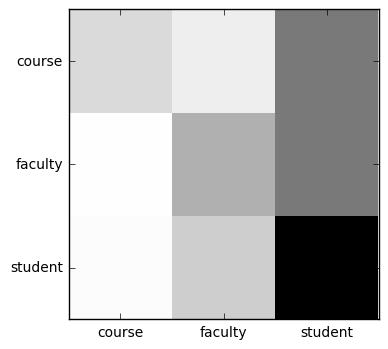


Feature set 2: 

training time:  18.039 s

predicting time:  255.704 s

0.87044534413
0.886639676113
0.862348178138
0.866396761134
0.865853658537
0.853658536585
0.918699186992
0.837398373984
0.882113821138
0.837398373984

0.868095191073

95% confidence interval: (0.85083307080998116, 0.88535731133675544)

Predicted  course  faculty  student  All
True                                    
course        181        9       31  221
faculty        16      199       32  247
student        18        9      319  346
All           215      217      382  814


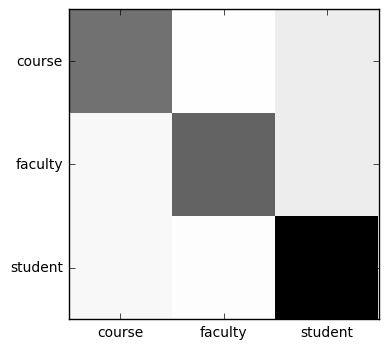


Feature set 3: 

training time:  0.005 s

predicting time:  0.248 s

0.724696356275
0.748987854251
0.80971659919
0.785425101215
0.817073170732
0.764227642276
0.780487804878
0.756097560976
0.768292682927
0.80487804878

0.77598828215

95% confidence interval: (0.75503356684335732, 0.7969429974566985)

Predicted  course  faculty  student  All
True                                    
course        174        5       42  221
faculty         8      182       57  247
student        12       52      282  346
All           194      239      381  814


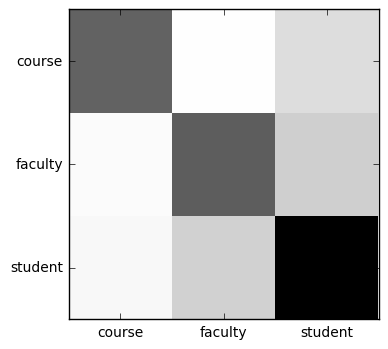

In [46]:
from sklearn.tree import DecisionTreeClassifier
def desTree(feature_set):
    classifier = DecisionTreeClassifier(random_state=0, min_samples_split=10, max_leaf_nodes=20, criterion='gini', max_depth=5, min_samples_leaf=1)

    t0 = time()
    x_train, x_test  = train_test_split(feature_set, test_size = 0.33, random_state=42)
    y_train, y_test = train_test_split(full_train_data['category'], test_size = 0.33, random_state=42)
    t0 = time()
    classifier.fit(x_train, y_train)
    print 'training time: ', round(time()-t0, 3), 's'
    print
    t1 = time()
    accuracies = cross_val_score(classifier, feature_set, full_train_data['category'], cv=10)
    print 'predicting time: ', round(time()-t1, 3), 's'
    print
    for acc in accuracies:
        print acc
    print
    print np.mean(accuracies)
    print
    print mean_confidence_interval(accuracies)
    print

    y_pred = classifier.fit(x_train, y_train).predict(x_test)
    
    conf = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    print conf
    im = plt.imshow(conf.iloc[0:3, 0:3], cmap='binary', interpolation='None')
    plt.xticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.yticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.show(im)
    return accuracies, conf, im
print "Feature set 1: "
print
desTree(features1)
print
print "Feature set 2: "
print
desTree(features2['tfidf'].tolist())
print
print "Feature set 3: "
print
desTree(features3)
print

The predicting strength of the first feature set is once again quite low. The classification of the second and third set of features is good in terms of accuracy but not as good as for example in the logistic regression model. The results for the tfidf-values are however better than those of the Knn-classifier, both in terms of accuracy and the correct predicting results as demonstrated in the confusion matrix.

### Random Forest

A potential improvement to the decision tree is the use of an ensemble learning method. In this instance, the choice went out to the random forest ensemble that combines a number of decision trees and tends to correct their habit of overfitting the training set. A grid search will again define the optimal parameters for the first and third set of features.

In [31]:
from sklearn.ensemble import RandomForestClassifier
def for_gridsearch(feature_set, clf, param_grid, cv=5):

    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    x_train, x_test  = train_test_split(feature_set, test_size = 0.33, random_state=42)
    y_train, y_test = train_test_split(full_train_data['category'], test_size = 0.33, random_state=42)
    start = time()
    grid_search.fit(x_train, y_train)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.grid_scores_)))

    print sorted(grid_search.grid_scores_, key=itemgetter(1), reverse=True)[1]
    return sorted(grid_search.grid_scores_, key=itemgetter(1), reverse=True)[1]

for_gridsearch(features1, RandomForestClassifier(), {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20]})
# for_gridsearch(features2['tfidf'].tolist(), RandomForestClassifier(), {"criterion": ["gini", "entropy"],
#               "min_samples_split": [2, 10, 20],
#               "max_depth": [None, 2, 5, 10],
#               "min_samples_leaf": [1, 5, 10],
#               "max_leaf_nodes": [None, 5, 10, 20],})
for_gridsearch(features3, RandomForestClassifier(), {"criterion": ["gini", "entropy"],
              "n_estimators" : [5, 10, 20, 50],                               
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "max_leaf_nodes": [5, 10, 20] }) 


GridSearchCV took 37.96 seconds for 96 candidate parameter settings.
mean: 0.53091, std: 0.01840, params: {'min_samples_split': 2, 'max_leaf_nodes': 10, 'criterion': 'entropy', 'max_depth': 10}

GridSearchCV took 209.67 seconds for 288 candidate parameter settings.
mean: 0.79030, std: 0.01476, params: {'min_samples_split': 2, 'max_leaf_nodes': 20, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}


mean: 0.79030, std: 0.01476, params: {'min_samples_split': 2, 'max_leaf_nodes': 20, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}

Feature set 1: 

training time:  0.369 s

predicting time:  3.758 s

0.51012145749
0.465587044534
0.502024291498
0.53036437247
0.467479674797
0.556910569106
0.532520325203
0.565040650407
0.49593495935
0.487804878049

0.51137882229

95% confidence interval: (0.48675061239885742, 0.53600703218163726)

Predicted  course  faculty  student  All
True                                    
course         61       10      150  221
faculty         9       62      176  247
student        20       23      303  346
All            90       95      629  814


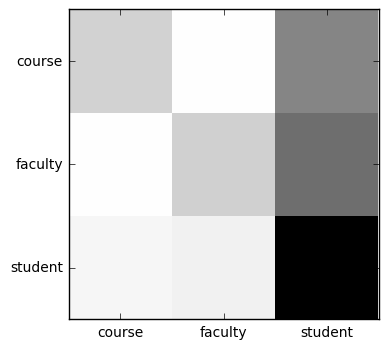


Feature set 2: 

training time:  5.916 s

predicting time:  75.636 s

0.801619433198
0.821862348178
0.813765182186
0.793522267206
0.731707317073
0.80081300813
0.768292682927
0.780487804878
0.841463414634
0.817073170732

0.797060662914

95% confidence interval: (0.77483597681378269, 0.81928534901486039)

Predicted  course  faculty  student  All
True                                    
course        174        1       46  221
faculty         1      141      105  247
student         0        4      342  346
All           175      146      493  814


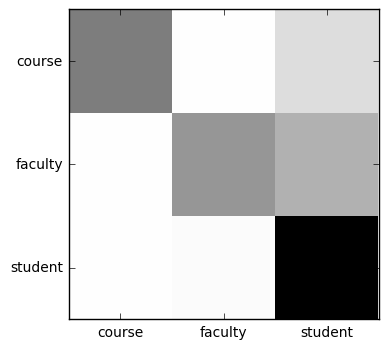


Feature set 3: 

training time:  0.306 s

predicting time:  3.398 s

0.732793522267
0.753036437247
0.842105263158
0.785425101215
0.825203252033
0.776422764228
0.792682926829
0.776422764228
0.768292682927
0.817073170732

0.786945788486

95% confidence interval: (0.76298067250569424, 0.81091090446675573)

Predicted  course  faculty  student  All
True                                    
course        177        3       41  221
faculty         9      179       59  247
student        15       48      283  346
All           201      230      383  814


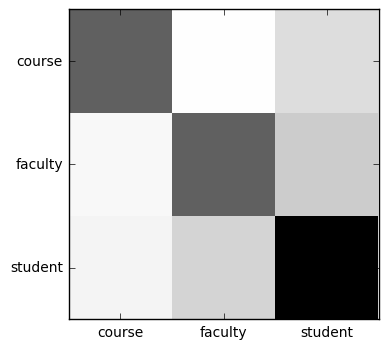

In [47]:
from sklearn.ensemble import RandomForestClassifier
def ranFor(feature_set):
    classifier = RandomForestClassifier(n_estimators=50, min_samples_leaf=5, min_samples_split= 10, criterion='entropy', max_depth=None, max_leaf_nodes=20)
    t0 = time()
    x_train, x_test  = train_test_split(feature_set, test_size = 0.33, random_state=42)
    y_train, y_test = train_test_split(full_train_data['category'], test_size = 0.33, random_state=42)
    t0 = time()
    classifier.fit(x_train, y_train)
    print 'training time: ', round(time()-t0, 3), 's'
    print
    t1 = time()
    accuracies = cross_val_score(classifier, feature_set, full_train_data['category'], cv=10)
    print 'predicting time: ', round(time()-t1, 3), 's'
    print
    for acc in accuracies:
        print acc
    print
    print np.mean(accuracies)
    print
    print mean_confidence_interval(accuracies)
    print

    y_pred = classifier.fit(x_train, y_train).predict(x_test)
    
    conf = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    print conf
    im = plt.imshow(conf.iloc[0:3, 0:3], cmap='binary', interpolation='None')
    plt.xticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.yticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.show(im)
    return accuracies, conf, im
print "Feature set 1: "
print
ranFor(features1)
print
print "Feature set 2: "
print
ranFor(features2['tfidf'].tolist())
print
print "Feature set 3: "
print
ranFor(features3)
print

The results for the random forrest are very similar to the ones of the decision tree and not really an improvement. The confusion matrix for the prediction of this second feature set indicates that the faculty webpages get confused quite a lot with the student webpages. This corresponds to the general conclusion of the dummy classifier that there is a tendency to predicting confusion towards the students class but it is remarkably high for the aforementioned model. It does not seems to be because of overfitting because using a forest of 200 trees returns similar results.

### Stochastic gradient descent

This last classifier is again a discriminative learner. The stochastic gradient descent was included for its proven efficiency with textual data, according to the Scikit documentation. Again using a grid search on the first and third set of features, some optimal parameters will be defined. It is expected that this classifier will have similar results to the logistic regression classifier since they are both discriminative learners.

In [33]:
from sklearn.linear_model import SGDClassifier
def sgd_gridsearch(feature_set, clf, param_grid, cv=5):

    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    x_train, x_test  = train_test_split(feature_set, test_size = 0.33, random_state=42)
    y_train, y_test = train_test_split(full_train_data['category'], test_size = 0.33, random_state=42)
    start = time()
    grid_search.fit(x_train, y_train)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.grid_scores_)))
    print grid_search.best_estimator_
#     print sorted(grid_search.grid_scores_, key=itemgetter(1), reverse=True)[1]
    return sorted(grid_search.grid_scores_, key=itemgetter(1), reverse=True)[1]

sgd_gridsearch(features1, SGDClassifier(), {"loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
              "penalty": ["none", "l2", "l1", "elasticnet"],
              "fit_intercept": [False, True],
              "n_iter": [1, 5, 20, 50]})
# sgd_gridsearch(features2['tfidf'].tolist(), SGDClassifier(), {"loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
#               "penalty": ["none", "l2", "l1", "elasticnet"],
#               "fit_intercept": [False, True],
#               "n_iter": [1, 5, 20, 50]})
sgd_gridsearch(features3, SGDClassifier(), {"loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
              "penalty": ["none", "l2", "l1", "elasticnet"],
              "fit_intercept": [False, True],
              "n_iter": [1, 5, 20, 50]})


GridSearchCV took 22.93 seconds for 160 candidate parameter settings.
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

GridSearchCV took 23.04 seconds for 160 candidate parameter settings.
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


mean: 0.76303, std: 0.01383, params: {'penalty': 'l2', 'loss': 'log', 'n_iter': 50, 'fit_intercept': True}

Feature set 1: 

training time:  0.028 s

predicting time:  0.533 s

0.465587044534
0.461538461538
0.481781376518
0.368421052632
0.471544715447
0.5
0.333333333333
0.313008130081
0.361788617886
0.422764227642

0.417976695961

95% confidence interval: (0.36931171457189665, 0.46664167735068635)

Predicted  course  faculty  student  All
True                                    
course         70      142        9  221
faculty        19      211       17  247
student        21      311       14  346
All           110      664       40  814


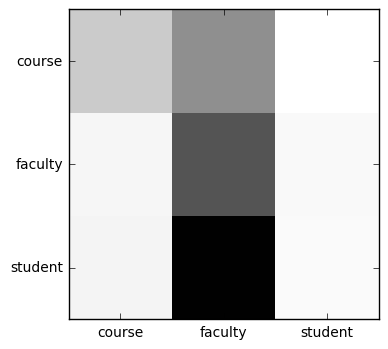


Feature set 2: 

training time:  47.868 s

predicting time:  630.737 s

0.943319838057
0.931174089069
0.902834008097
0.919028340081
0.914634146341
0.955284552846
0.894308943089
0.865853658537
0.906504065041
0.906504065041

0.91394457062

95% confidence interval: (0.89574152492385439, 0.93214761631573595)

Predicted  course  faculty  student  All
True                                    
course        203        2       16  221
faculty         1      222       24  247
student         2        3      341  346
All           206      227      381  814


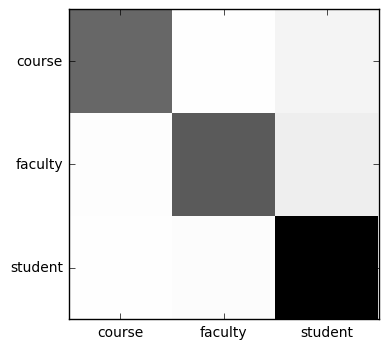


Feature set 3: 

training time:  0.031 s

predicting time:  0.5 s

0.7004048583
0.712550607287
0.825910931174
0.789473684211
0.821138211382
0.70325203252
0.723577235772
0.784552845528
0.752032520325
0.80081300813

0.761370593463

95% confidence interval: (0.72631401392728723, 0.79642717299875221)

Predicted  course  faculty  student  All
True                                    
course        180        1       40  221
faculty        16      187       44  247
student        21       99      226  346
All           217      287      310  814


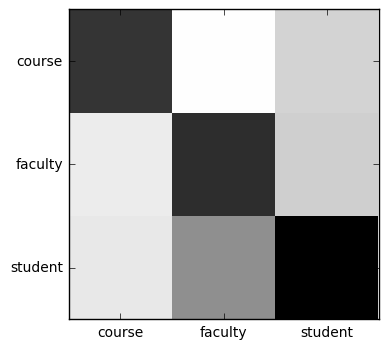

In [48]:
from sklearn.linear_model import SGDClassifier
def sgd(feature_set):
    sgd_clf = SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=20, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
    t0 = time()
    x_train, x_test  = train_test_split(feature_set, test_size = 0.33, random_state=42)
    y_train, y_test = train_test_split(full_train_data['category'], test_size = 0.33, random_state=42)
    t0 = time()
    sgd_clf.fit(x_train, y_train)
    print 'training time: ', round(time()-t0, 3), 's'
    print
    t1 = time()
    accuracies = cross_val_score(sgd_clf, feature_set, full_train_data['category'], cv=10)
    print 'predicting time: ', round(time()-t1, 3), 's'
    print
    for acc in accuracies:
        print acc
    print
    print np.mean(accuracies)
    print
    print mean_confidence_interval(accuracies)
    print

    y_pred = sgd_clf.fit(x_train, y_train).predict(x_test)
    
    conf = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    print conf
    im = plt.imshow(conf.iloc[0:3, 0:3], cmap='binary', interpolation='None')
    plt.xticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.yticks([0, 1, 2], ['course', 'faculty', 'student'])
    plt.show(im)
    return accuracies, conf, im
print "Feature set 1: "
print
sgd(features1)
print
print "Feature set 2: "
print
sgd(features2['tfidf'].tolist())
print
print "Feature set 3: "
print
sgd(features3)
print

As expected, the stochastic gradient descent classifier performs very good on the tfidf-features. Although there is still some confusion between the faculty and the student class, this is limited to very acceptable terms. Furthermore, the mean accuracy of the 10-fold cross-validation results reach up to more than 93% and 95% of the future true means will be situated between an accuracy of 91.1% and 96.1%. These results are as expected closely related to but even higher than the ones of the logistic regression model for the tfidf-features. A next, more thorough evaluation will have to define the best model for predicting the test data.

## 3. Evaluation

It appears that the models with the best predicting performance are the ones that use the tfidf-values as features and have a discriminative learner with custom parameters as their classifier. More concrete, this comes down to the simple logistic regression classifier and the more complex stochastic gradient descent classifier. The decision tree performed relatively good as well. In this concluding part, the results of these three classifiers will be put next to each other to determine which one is the best. After that, the model with the best predicting performance will be applied to the test data.

Baseline classifier model: 
training time:  0.001 s

predicting time:  1.379 s

0.36032388664
0.400809716599
0.372469635628
0.380566801619
0.373983739837
0.29674796748
0.39837398374
0.325203252033
0.378048780488
0.382113821138

0.36686415852

95% confidence interval: (0.34366264324039103, 0.3900656737998644)

Predicted  course  faculty  student  All
True                                    
course         50       61      110  221
faculty        65       80      102  247
student        73      102      171  346
All           188      243      383  814


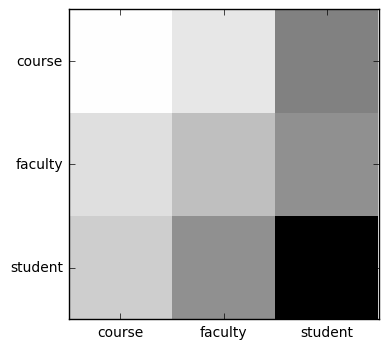


First model, tfidf-features with logistic regression classifier: 

training time:  1.018 s

predicting time:  14.884 s

0.939271255061
0.927125506073
0.886639676113
0.898785425101
0.906504065041
0.943089430894
0.910569105691
0.89837398374
0.910569105691
0.882113821138

0.910304137454

95% confidence interval: (0.89552544406165335, 0.92508283084700671)

Predicted  course  faculty  student  All
True                                    
course        195        5       21  221
faculty         3      226       18  247
student        10       11      325  346
All           208      242      364  814


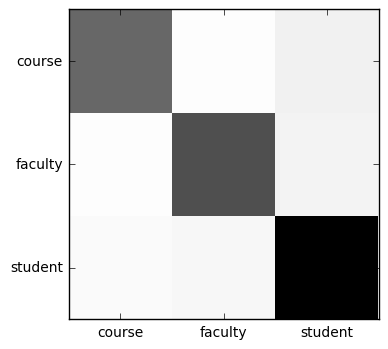


Second model, tfidf-features with decision tree classifier: 

training time:  17.191 s

predicting time:  239.972 s

0.87044534413
0.886639676113
0.862348178138
0.866396761134
0.865853658537
0.853658536585
0.918699186992
0.837398373984
0.882113821138
0.837398373984

0.868095191073

95% confidence interval: (0.85083307080998116, 0.88535731133675544)

Predicted  course  faculty  student  All
True                                    
course        181        9       31  221
faculty        16      199       32  247
student        18        9      319  346
All           215      217      382  814


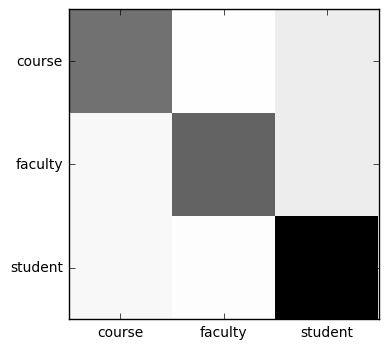


Third model, tfidf-features with stochastic gradient descent: 
training time:  46.862 s

predicting time:  596.742 s

0.935222672065
0.943319838057
0.894736842105
0.914979757085
0.910569105691
0.951219512195
0.918699186992
0.861788617886
0.886178861789
0.910569105691

0.912728349956

95% confidence interval: (0.89336098209470516, 0.93209571781642342)

Predicted  course  faculty  student  All
True                                    
course        204        4       13  221
faculty         1      228       18  247
student         2        4      340  346
All           207      236      371  814


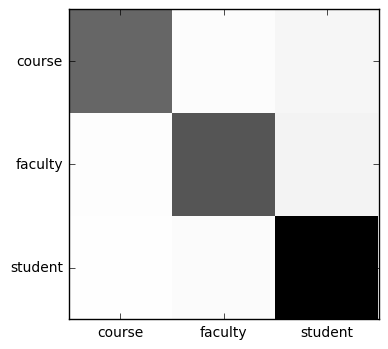

In [49]:
print "Baseline classifier model: "
baseline = dumClass(features2['tfidf'].tolist())
print
print "First model, tfidf-features with logistic regression classifier: "
print
log_model = logReg(features2['tfidf'].tolist())
print
print "Second model, tfidf-features with decision tree classifier: "
print 
tree_model = desTree(features2['tfidf'].tolist())
print
print "Third model, tfidf-features with stochastic gradient descent: "
sgd_model = sgd(features2['tfidf'].tolist())

With a 95% confidence interval between 0.90 and 0.95, the stochastic gradient descent classifier performs slightly better than the other two classifiers, also in terms of minimising confusion. It is however the question whether this small difference is also a significant difference. A paired t-test will determine whether there is a real difference between the predicting accuracy of the logistic regression model, the dummy baseline, the decision tree model and the stochastic gradient descent model. For the two-tailed p-value, the common 0.05 value was taken as the benchmark for statistical significance.

In [50]:
def Ttest(first, second):
    tt = stats.ttest_rel(first, second)
    print "t = %.4f" %tt[0]
    print "The two-paired p-value is %.4f" %tt[1]
print "Statistics for accuracies of logistic regression and baseline dummy classifier: "
Ttest(log_model[0].tolist(),baseline[0].tolist())
print
print "Statistics for accuracies of logistic regression and decision tree: "
Ttest(log_model[0].tolist(),tree_model[0].tolist())
print
print "Statistics for accuracies of logistic regression and SGD: "
Ttest(log_model[0].tolist(),sgd_model[0].tolist())
print
print "Statistics for accuracies of decision tree and SGD: "
Ttest(tree_model[0].tolist(),sgd_model[0].tolist())

Statistics for accuracies of logistic regression and baseline dummy classifier: 
t = 38.8378
The two-paired p-value is 0.0000

Statistics for accuracies of logistic regression and decision tree: 
t = 4.9887
The two-paired p-value is 0.0008

Statistics for accuracies of logistic regression and SGD: 
t = -0.3921
The two-paired p-value is 0.7041

Statistics for accuracies of decision tree and SGD: 
t = -4.6255
The two-paired p-value is 0.0012


The differences in predicting performance between the logistic regression model and the dummy classifier, the logistic regression model and the decision tree model, the decision tree model and the SGD model are all statistically significant as demonstrated by their two-paired p-values. The difference between the mean accuracies for the logistic regression model and the SGD model is not significant. It seems like the simpler logistic regression model does not perform significantly worse than the more complex SGD model. A last option to improve one of these models is to combine the tfidf-features with the other feature sets.

First model, combined features with logistic regression classifier: 

training time:  5.849 s

predicting time:  26.914 s

0.906882591093
0.874493927126
0.87044534413
0.894736842105
0.886178861789
0.894308943089
0.890243902439
0.886178861789
0.886178861789
0.890243902439

0.887989203779

95% confidence interval: (0.88063056936355666, 0.89534783819379815)

Predicted  course  faculty  student  All
True                                    
course        201        4       16  221
faculty         8      216       23  247
student        13       15      318  346
All           222      235      357  814


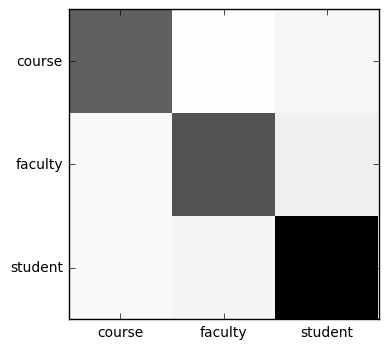


Second model, combined features with stochastic gradient descent
training time:  45.691 s

predicting time:  612.33 s

0.736842105263
0.765182186235
0.825910931174
0.740890688259
0.857723577236
0.910569105691
0.80487804878
0.80487804878
0.772357723577
0.841463414634

0.806069582963

95% confidence interval: (0.76682513819423503, 0.84531402773183695)

Predicted  course  faculty  student  All
True                                    
course        189        9       23  221
faculty         8      161       78  247
student        16        5      325  346
All           213      175      426  814


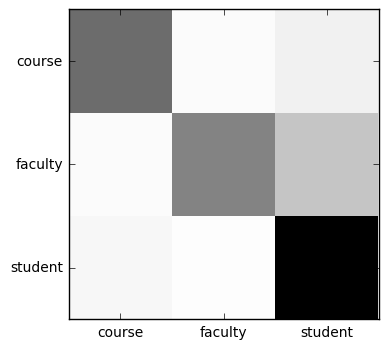

In [51]:
print "First model, combined features with logistic regression classifier: "
print
combined = sp.hstack([features1, features2['tfidf'].tolist(), features3])
new_log_model = logReg(combined)
print
# new_tree_model = desTree(combined)
print "Second model, combined features with stochastic gradient descent"
new_sgd_model = sgd(combined)

Since none of the combined models seem to perform better, the best models in terms of predicting performance are still the SGD classifier and the logistic regression classifier with the tfidf-features. Because the difference between the logistic regression model and the SGD model is not statistically significant and because the former is faster, the choice went out to the logistic regression model. This means that the model with only the tfidf features and the logistic regression classifier will be used as the final predicting model.

### Predicting the test set

Code for loading the eventual test_data. Then use .predict(test_data) from scikit

In [52]:
def testData(path):
    data = pd.DataFrame(index=[], columns=['text'])
    ind = 0
    for f in os.listdir(path+'\\'):  
            content = open(path+'\\'+f).read()
            content = BeautifulSoup(content).get_text()
            data.loc[ind] = [content]
            ind = ind + 1
    return data
# Load the data
test_data = testData('C:\Users\Tim\Documents\KU Leuven\Master digital humanities\Introduction to data mining\Project\\dm-project\\test')
print test_data.shape
# !! Don't re-fit on test data !! 
test_data.head()

(1231, 1)


,text
0,\nCS 556 Interactive Software Systems\n\n\nInt...
1,"Date: Mon, 25 Nov 1996 23:14:31 GMT\nServer: N..."
2,"Date: Monday, 25-Nov-96 23:07:51 GMT\nServer: ..."
3,"Date: Monday, 25-Nov-96 23:08:09 GMT\nServer: ..."
4,"Date: Thu, 21 Nov 1996 20:37:51 GMT\nServer: N..."


In [53]:
from sklearn import preprocessing
full = []
for item in test_data['text']:   
    plain_text = BeautifulSoup(item).get_text()
    full.append(plain_text)
test_data['plainText'] = full
stop = nltk.corpus.stopwords.words('english')
for i in range(len(test_data['plainText'])):
    fil = []
    for word in test_data['plainText'][i].split():
        if word.lower() not in stop:
            fil.append(word)
    test_data['plainText'][i] = " ".join(fil)
test_data.head()


,text,plainText
0,\nCS 556 Interactive Software Systems\n\n\nInt...,CS 556 Interactive Software Systems Introducti...
1,"Date: Mon, 25 Nov 1996 23:14:31 GMT\nServer: N...","Date: Mon, 25 Nov 1996 23:14:31 GMT Server: NC..."
2,"Date: Monday, 25-Nov-96 23:07:51 GMT\nServer: ...","Date: Monday, 25-Nov-96 23:07:51 GMT Server: N..."
3,"Date: Monday, 25-Nov-96 23:08:09 GMT\nServer: ...","Date: Monday, 25-Nov-96 23:08:09 GMT Server: N..."
4,"Date: Thu, 21 Nov 1996 20:37:51 GMT\nServer: N...","Date: Thu, 21 Nov 1996 20:37:51 GMT Server: NC..."


In [54]:
X_new_counts = count_vect.transform(test_data['plainText'])
X_new_tfidf = transformer.transform(X_new_counts)

In [56]:
classifier = LogisticRegression(penalty='l1', random_state=10,dual=False, class_weight="balanced", fit_intercept= False)
t0 = time()
classifier.fit(features2['tfidf'].tolist(), full_train_data['category'])
print 'training time: ', round(time()-t0, 3), 's'
print
pred = classifier.predict(X_new_tfidf)
test_data['predictions'] = pred

training time:  2.709 s



In [57]:
test_data.head(200)

,text,plainText,predictions
0,\nCS 556 Interactive Software Systems\n\n\nInt...,CS 556 Interactive Software Systems Introducti...,course
1,"Date: Mon, 25 Nov 1996 23:14:31 GMT\nServer: N...","Date: Mon, 25 Nov 1996 23:14:31 GMT Server: NC...",faculty
2,"Date: Monday, 25-Nov-96 23:07:51 GMT\nServer: ...","Date: Monday, 25-Nov-96 23:07:51 GMT Server: N...",faculty
3,"Date: Monday, 25-Nov-96 23:08:09 GMT\nServer: ...","Date: Monday, 25-Nov-96 23:08:09 GMT Server: N...",faculty
4,"Date: Thu, 21 Nov 1996 20:37:51 GMT\nServer: N...","Date: Thu, 21 Nov 1996 20:37:51 GMT Server: NC...",faculty
5,"Date: Wed, 20 Nov 1996 23:20:59 GMT\nServer: N...","Date: Wed, 20 Nov 1996 23:20:59 GMT Server: NC...",course
6,"Date: Tue, 26 Nov 1996 16:22:19 GMT\nServer: N...","Date: Tue, 26 Nov 1996 16:22:19 GMT Server: NC...",student
7,"Date: Tue, 26 Nov 1996 18:53:51 GMT\nServer: N...","Date: Tue, 26 Nov 1996 18:53:51 GMT Server: NC...",course
8,"Date: Tue, 26 Nov 1996 18:53:35 GMT\nServer: N...","Date: Tue, 26 Nov 1996 18:53:35 GMT Server: NC...",course
9,"Date: Tue, 26 Nov 1996 18:53:26 GMT\nServer: N...","Date: Tue, 26 Nov 1996 18:53:26 GMT Server: NC...",course
